In [1]:
import re
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.dates as mdates
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
ig_after = pd.read_csv("final_after.csv")

# Print a few rows
print(ig_after.head())

                                    postUrl                         timestamp  \
0  https://www.instagram.com/p/DB9Etn9J3f6/  2024-11-05 05:37:40.363000+00:00   
1  https://www.instagram.com/p/DB-PoVFIS46/  2024-11-05 16:31:34.840000+00:00   
2  https://www.instagram.com/p/DCCGyYPvWFg/  2024-11-07 04:32:04.513000+00:00   
3  https://www.instagram.com/p/DB_iglBu3i7/  2024-11-06 04:31:48.394000+00:00   
4  https://www.instagram.com/p/DB7ZFh1yx0f/  2024-11-05 05:35:22.199000+00:00   

           username          fullName  \
0     thefreebieguy   The Freebie Guy   
1  pipsqueak_thedog         Pipsqueak   
2        cuzzowurst               NaN   
3        themilajam          MILA JAM   
4        jakubmosur  Jakub Kuba Mosur   

                                             caption  likeCount  commentCount  \
0  Election Day Freebies! 🇺🇸 Lots of discounts an...      19939            98   
1  Tomorrow isn’t just #tongueouttuesday, it’s al...        914            14   
2  #fyp #explore #viral

In [2]:
print("Total rows:", len(ig_after))
print("Unique postUrls:", ig_after['postUrl'].nunique())

Total rows: 1481
Unique postUrls: 1481


In [3]:
ig_after.isnull().sum()

postUrl            0
timestamp          0
username           0
fullName          45
caption            0
likeCount          0
commentCount       0
location        1063
matches            0
dtype: int64

In [4]:
def clean_caption(text):
    if not isinstance(text, str):
        return ""
    # Remove URLs
    text = re.sub(r"http\S+", "", text)
    # Potentially remove newlines, extra spaces
    text = text.replace('\n', ' ').strip()
    return text

ig_after['caption_clean'] = ig_after['caption'].apply(clean_caption)

In [5]:
sia = SentimentIntensityAnalyzer()

def get_vader_score(text):
    # If text is not a string, return 0
    if not isinstance(text, str):
        return 0.0
    scores = sia.polarity_scores(text)
    return scores['compound']

ig_after['sentiment_score'] = ig_after['caption_clean'].apply(get_vader_score)

In [6]:
print(ig_after['sentiment_score'].describe())

count    1481.000000
mean        0.259437
std         0.464451
min        -0.991300
25%         0.000000
50%         0.000000
75%         0.678100
max         0.999400
Name: sentiment_score, dtype: float64


In [7]:
df_sorted = ig_after.sort_values('sentiment_score')
print("Most Negative Captions:")
print(df_sorted.head(5)[['caption_clean','sentiment_score']])

print("\nMost Positive Captions:")
print(df_sorted.tail(5)[['caption_clean','sentiment_score']])

Most Negative Captions:
                                          caption_clean  sentiment_score
1342  I’m shocked and heartbroken. \r \r I’m reminde...          -0.9913
311   I want to make it clear that I staunchly oppos...          -0.9882
329   I may not be American but I grew up in the Pen...          -0.9845
1272  The Heavy Weapons Guy, more commonly known as ...          -0.9788
929   There is so much misinformation being put out ...          -0.9782

Most Positive Captions:
                                         caption_clean  sentiment_score
839  I think we all feel a bit of heaviness and a w...           0.9980
840  Dear friends, “Since God so loved us, we shoul...           0.9982
121  read the caption ⬇️\r •\r •\r 2024 Election Sa...           0.9985
640  read the caption ⬇️\r •\r •\r 2024 Election Sa...           0.9985
552  I Love America - Released as a single in 1983 ...           0.9994


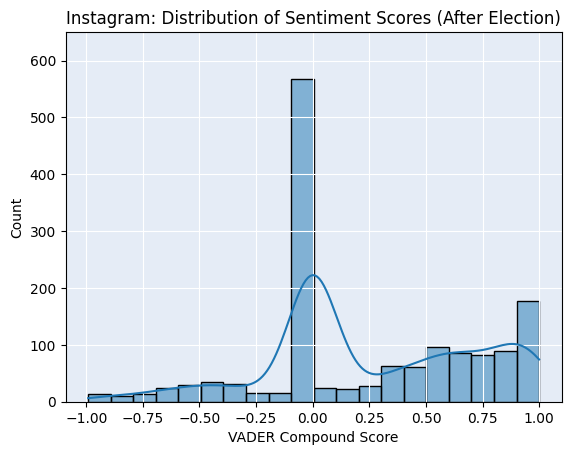

In [8]:
sns.histplot(data=ig_after, x='sentiment_score', bins=20, kde=True)

plt.grid(True, color='white', linestyle='-', linewidth=0.8)
plt.gca().set_facecolor("#E5ECF6")
plt.title("Instagram: Distribution of Sentiment Scores (After Election)")
plt.xlabel("VADER Compound Score")
plt.ylabel("Count")
plt.ylim(0, 650)
plt.show()

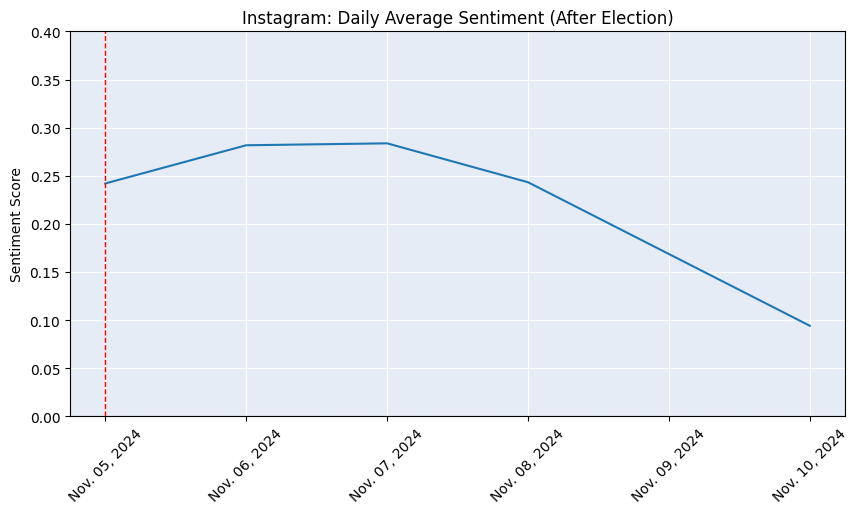

In [9]:
ig_after['timestamp'] = pd.to_datetime(ig_after['timestamp'], errors='coerce')
ig_after['date'] = ig_after['timestamp'].dt.date
daily_sentiment = ig_after.groupby('date')['sentiment_score'].mean().reset_index()

# Plot
plt.figure(figsize=(10,5))
plt.gca().set_facecolor("#E5ECF6")
sns.lineplot(data=daily_sentiment, x='date', y='sentiment_score')
plt.title("Instagram: Daily Average Sentiment (After Election)")
plt.xlabel(None)
plt.ylabel("Sentiment Score")
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b. %d, %Y'))
plt.ylim(0, 0.4)
plt.yticks(np.arange(0, 0.41, 0.05))
plt.axhline(0, color='lightgray', linestyle='--', linewidth=1)

# Convert string date to datetime for Nov 5th, 2024
nov_5th = pd.to_datetime('2024-11-05')
plt.axvline(nov_5th, color='red', linestyle='--', linewidth=1)

plt.grid(True, color='white', linestyle='-', linewidth=0.8)
plt.show()

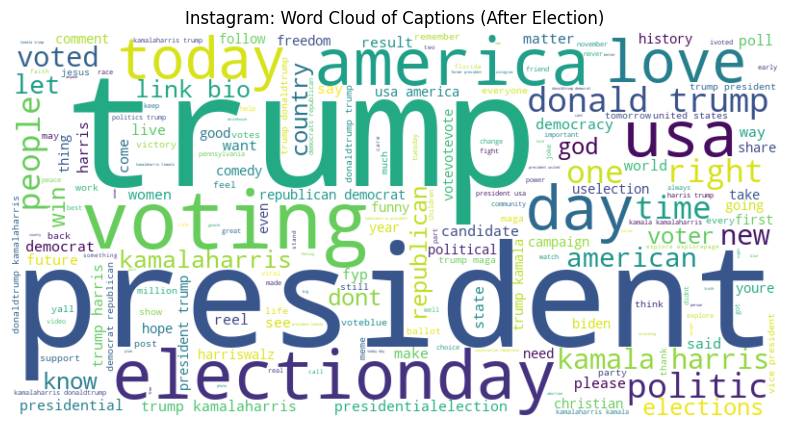

In [10]:
# Reload the dataset
ig_after = pd.read_csv("final_after.csv")

# Clean caption function
def clean_caption(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove punctuation and numbers
    text = text.replace('\n', ' ').strip()  # Remove newlines
    return text

ig_after['caption_clean'] = ig_after['caption'].apply(clean_caption)

# Tokenization and stopword removal
stop_words = set(stopwords.words('english'))

def process_text(text):
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    words = [word for word in words if len(word) > 2]
    return words

# Apply text processing
ig_after['caption_tokens'] = ig_after['caption_clean'].apply(process_text)

# Flatten list of single words
all_words = [word for tokens in ig_after['caption_tokens'] for word in tokens]

# Remove multi-word phrases
for phrase in ["vote election", "election vote"]:
    words = phrase.split()
    all_words = [word for word in all_words if word not in words]

# Generate Word Cloud
wordcloud = WordCloud(
    width=800, height=400,
    background_color='white',
    colormap='viridis',
    max_words=200
).generate(" ".join(all_words))

# Display Word Cloud
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Instagram: Word Cloud of Captions (After Election)")
plt.show()